In [1]:
import os
from time import time
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn.functional as F
import torch.utils.data as torch_data

In [3]:
from model import Generator, Discriminator
from utils import fastMRIData, compare_imgs, load_torch_model

In [4]:
# Only to fix the Mac's problem
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [5]:
acceleration = 2

PATH_TO_SOURCE_TRAIN = 'data/ax_t2_single_source_train'
PATH_TO_SOURCE_VAL = 'data/ax_t2_single_source_val'
PATH_TO_SAMPLED_TRAIN = f'data/ax_t2_single_sampled_x{acceleration}_train'
PATH_TO_SAMPLED_VAL = f'data/ax_t2_single_sampled_x{acceleration}_val'

PATH_TO_MODELS = 'models'
PATH_TO_LOGS = 'logs'

RANDOM_STATE = 42

In [8]:
os.makedirs(PATH_TO_MODELS, exist_ok=True)
os.makedirs(PATH_TO_LOGS, exist_ok=True)
#os.makedirs(LOGGING_DIR, exist_ok=True)

## Load the data

In [9]:
fmri_train = fastMRIData(PATH_TO_SOURCE_TRAIN, PATH_TO_SAMPLED_TRAIN)
fmri_val = fastMRIData(PATH_TO_SOURCE_VAL, PATH_TO_SAMPLED_VAL)

len(fmri_train), len(fmri_val)

(47024, 11756)

In [10]:
fmri_train.images = fmri_train.images[:2]
fmri_val.images = fmri_val.images[:2]

	MAE	PSNR	SSIM
score	0.060	20.983	0.587


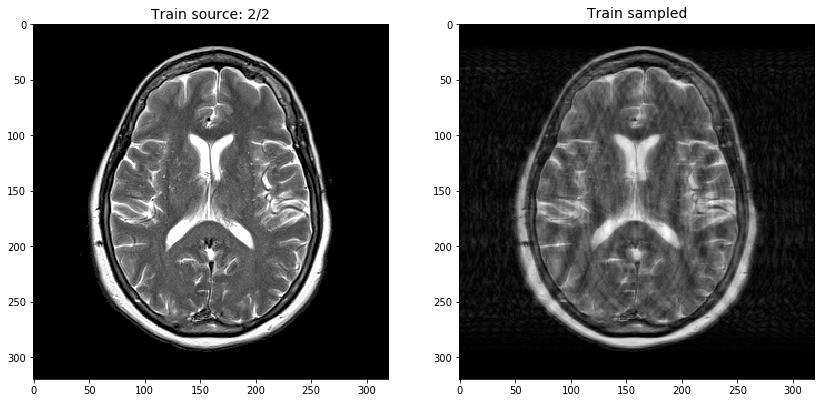

	MAE	PSNR	SSIM
score	0.051	22.244	0.678


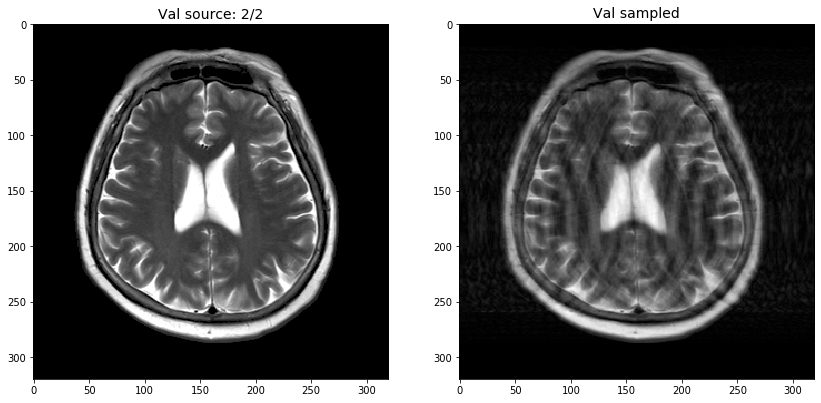

In [11]:
for fmri, type in zip([fmri_train, fmri_val], ['Train', 'Val']):

    i = np.random.randint(0, len(fmri))
    source, sampled = fmri.__getitem__(i)

    fig, axis = plt.subplots(1, 2, figsize=(14, 12))
    axis[0].imshow(source[0], cmap='gray', vmin=0, vmax=1)
    axis[0].set_title(f'{type} source: {i+1}/{len(fmri)}', fontsize=14)
    axis[1].imshow(sampled[0], cmap='gray', vmin=0, vmax=1)
    axis[1].set_title(f'{type} sampled', fontsize=14)
    
    compare_imgs(source, sampled, verbose=True)

    plt.show()

## Training

In [19]:
def model_train(epochs, G, D, G_optimizer, D_optimizer, l1_lambda, device,
                train_loader, val_loader, models_dir=None, log_file=None, verbose=True):

    if log_file:
        with open(log_file, 'a') as f:
            params = dumps_train_params(epochs, l1_lambda, G_optimizer, D_optimizer)
            f.write(params + '\n\n')

    start_time = time()
    G.to(device)
    D.to(device)

    best_discriminator_val_loss = np.inf
    best_generator_val_loss = np.inf
    freq = max(epochs // 20, 1)

    train_losses = {'generator' : [],
                    'discriminator': []
                   }
    val_losses =   {'generator' : [],
                    'discriminator': []
                   }

    for epoch in range(1, epochs+1):

        epoch_start = time()
        G.train()
        D.train()

        for source, sampled in train_loader:
            source = source.to(device)
            sampled = sampled.to(device)

            discriminator_train_loss = train_discriminator(sampled, source, G, D, D_optimizer)
            generator_train_loss = train_generator(sampled, source, G, D, l1_lambda, G_optimizer)

        epoch_time = time() - epoch_start

        G.eval()
        D.eval()
        for source, sampled in val_loader:
            source = source.to(device)
            sampled = sampled.to(device)

            discriminator_val_loss = discriminator_loss(sampled, source, G, D)
            generator_val_loss = generator_loss(sampled, source, G, D, l1_lambda)

        if models_dir and best_discriminator_val_loss > discriminator_val_loss:

            path_to_model = os.path.join(models_dir, f'D_{epoch}.pth')
            best_discriminator_val_loss = discriminator_val_loss
            torch.save(D.state_dict(), path_to_model)

        if models_dir and best_generator_val_loss > generator_val_loss:

            path_to_model = os.path.join(models_dir, f'G_{epoch}.pth')
            best_generator_val_loss = generator_val_loss
            torch.save(G.state_dict(), path_to_model)

        log_line = f'Epoch {epoch}/{epochs}\tTrain loss: [Dis: {discriminator_train_loss:.4f}, ' + \
                   f'Gen: {generator_train_loss:.4f}],\tVal loss: [' + \
                   f'Dis: {discriminator_val_loss:.4f}, Gen: {generator_val_loss:.4f}] | {epoch_time:.1f} sec'

        if verbose and epoch%freq == 0:
            print(log_line)

        if log_file:
            with open(log_file, 'a') as f:
                f.write(log_line + '\n')

    train_time = time() - start_time
    if log_file:
        with open(log_file, 'a') as f:
            f.write(f'\nTrain time: {train_time/60:.1f} min\n')

In [27]:
def dumps_train_params(epochs, l1_lambda, G_optimizer, D_optimizer):
    str_params = {'random_state': RANDOM_STATE,
                  'epochs': epochs,
                  'l1_lambda': l1_lambda,
                  'G_optimizer': str(G_optimizer).replace('\n', '' ),
                  'D_optimizer': str(D_optimizer).replace('\n', '' )
                 }

    return str(str_params)


def write_train_params(log_file, epochs, l1_lambda, G_optimizer, D_optimizer):
    with open(log_file, 'a') as f:
        params = dumps_train_params(epochs, l1_lambda, G_optimizer, D_optimizer)
        f.write(params + '\n\n')


class FastMRI_Train:
    def __init__(self, G, D, G_optimizer, D_optimizer, l1_lambda, acceleration,
                 path_to_models=None, path_to_logs=None, device='cpu'):

        self.G = G.to(device)
        self.D = D.to(device)
        self.G_optimizer = G_optimizer
        self.D_optimizer = D_optimizer
        self.l1_lambda = l1_lambda
        self.acceleration = acceleration
        self.device = device
        
        self.train_losses = {'generator' : [],
                             'discriminator': []
                            }
        self.val_losses =   {'generator' : [],
                             'discriminator': []
                            }

        self.best_discriminator_val_loss = np.inf
        self.best_generator_val_loss = np.inf

        now_datetime = datetime.now().strftime('%Y-%m-%d-%H.%M.%S')

        if path_to_logs:
            path_to_logs = os.path.join(path_to_logs, f'x{acceleration}')
            self.log_file = os.path.join(path_to_logs, now_datetime)
            os.makedirs(path_to_logs, exist_ok=True)
        else:
            self.log_file = None
        
        if path_to_models:
            self.models_dir = os.path.join(path_to_models, f'x{acceleration}', now_datetime)
            os.makedirs(self.models_dir, exist_ok=True)
        else:
            self.models_dir = None

    def discriminator_loss(self, sampled, source):
        D_result = self.D(sampled, source).squeeze()
        true_answers = torch.ones(D_result.size()).to(self.device)

        D_real_loss = F.binary_cross_entropy(D_result, true_answers)

        generated = self.G(sampled)
        D_result = self.D(sampled, generated).squeeze()
        false_answers = torch.zeros(D_result.size()).to(self.device)

        D_fake_loss = F.binary_cross_entropy(D_result, false_answers)

        loss = (D_real_loss + D_fake_loss) / 2
        return loss

    def train_discriminator(self, sampled, source):
        self.D.zero_grad()

        loss = self.discriminator_loss(sampled, source)

        loss.backward()
        self.D_optimizer.step()

        return loss.data

    def generator_loss(self, sampled, source):
        generated = self.G(sampled)
        D_result = self.D(sampled, generated).squeeze()
        true_answers = torch.ones(D_result.size()).to(self.device)

        loss = F.binary_cross_entropy(D_result, true_answers) + self.l1_lambda*F.l1_loss(generated, source)
        return loss

    def train_generator(self, sampled, source):
        self.G.zero_grad()

        loss = self.generator_loss(sampled, source)

        loss.backward()
        self.G_optimizer.step()

        return loss.data

    def train_step(self, train_loader):
        self.G.train()
        self.D.train()

        discriminator_train_losses = []
        generator_train_losses = []

        for source, sampled in train_loader:
            source = source.to(self.device)
            sampled = sampled.to(self.device)

            discriminator_train_losses.append(self.train_discriminator(sampled, source))
            generator_train_losses.append(self.train_generator(sampled, source))

        return sum(discriminator_train_losses) / len(discriminator_train_losses), \
               sum(generator_train_losses) / len(generator_train_losses)

    def eval(self, val_loader):
        self.G.eval()
        self.D.eval()

        discriminator_val_losses = []
        generator_val_losses = []

        for source, sampled in val_loader:
            source = source.to(self.device)
            sampled = sampled.to(self.device)

            discriminator_val_losses.append(self.discriminator_loss(sampled, source))
            generator_val_losses.append(self.generator_loss(sampled, source))

        return sum(discriminator_val_losses) / len(discriminator_val_losses), \
               sum(generator_val_losses) / len(generator_val_losses)

    def save_best_D(self):
        last_discriminator_val_loss = self.val_losses['discriminator'][-1]
        
        if self.best_discriminator_val_loss > last_discriminator_val_loss:

            path_to_model = os.path.join(self.models_dir, f'D_best.pth')
            self.best_discriminator_val_loss = last_discriminator_val_loss
            torch.save(self.D.state_dict(), path_to_model)

    def save_best_G(self):
        last_generator_val_loss = self.val_losses['generator'][-1]
        
        if self.best_generator_val_loss > last_generator_val_loss:

            path_to_model = os.path.join(self.models_dir, f'G_best.pth')
            self.best_generator_val_loss = last_generator_val_loss
            torch.save(self.G.state_dict(), path_to_model)

    def get_log_line(self, epoch, epochs, epoch_time):
        last_generator_train_loss = self.train_losses['generator'][-1]
        last_discriminator_train_loss = self.train_losses['discriminator'][-1]
        last_generator_val_loss = self.val_losses['generator'][-1]
        last_discriminator_val_loss = self.val_losses['discriminator'][-1]

        log_line = f'Epoch {epoch}/{epochs}\tTrain loss: [Dis: {last_discriminator_train_loss:.4f}, ' + \
                   f'Gen: {last_generator_train_loss:.4f}],\tVal loss: [' + \
                   f'Dis: {last_discriminator_val_loss:.4f}, Gen: {last_generator_val_loss:.4f}] ' + \
                   f'| {epoch_time:.1f} sec'

        return log_line

    def train(self, epochs, train_loader, val_loader=None, verbose=True, logging=False):
        start_time = time()

        if logging:
            assert self.log_file
            write_train_params(self.log_file, epochs, 
                               self.l1_lambda, self.G_optimizer, self.D_optimizer)

        freq = max(epochs // 20, 1)
        
        for epoch in range(1, epochs+1):
            epoch_start = time()

            discriminator_train_loss, generator_train_loss = self.train_step(train_loader)
            self.train_losses['generator'].append(generator_train_loss)
            self.train_losses['discriminator'].append(discriminator_train_loss)

            if val_loader:
                discriminator_val_loss, generator_val_loss = self.eval(train_loader)
                self.val_losses['generator'].append(generator_val_loss)
                self.val_losses['discriminator'].append(discriminator_val_loss)
     
            if val_loader and self.models_dir:
                self.save_best_D()
                self.save_best_G()

            epoch_time = time() - epoch_start
            log_line = self.get_log_line(epoch, epochs, epoch_time)

            if verbose and epoch%freq == 0:
                print(log_line)

            if logging:
                with open(self.log_file, 'a') as f:
                    f.write(log_line + '\n')

        train_time = time() - start_time
        if logging:
            with open(self.log_file, 'a') as f:
                f.write(f'\nTrain time: {train_time/60:.1f} min\n')

In [28]:
torch.manual_seed(RANDOM_STATE)

G = Generator(64)
D = Discriminator(64)

l1_lambda = 100
lr = 0.0002
betas = (0.5, 0.999)

G_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=betas)
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=betas)

train_loader = torch_data.DataLoader(fmri_train, batch_size=1, shuffle=True) 
val_loader = torch_data.DataLoader(fmri_val, batch_size=len(fmri_val), shuffle=False) 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cpu


In [29]:
%%time
pix2pix = FastMRI_Train(G, D, G_optimizer, D_optimizer, l1_lambda, 
                        acceleration, PATH_TO_MODELS, PATH_TO_LOGS, device)

epochs = 4
pix2pix.train(epochs, train_loader, val_loader, verbose=True, logging=True)

Epoch 1/4	Train loss: [Dis: 0.7684, Gen: 41.1546],	Val loss: [Dis: 0.6828, Gen: 41.7859] | 9.4 sec
Epoch 2/4	Train loss: [Dis: 0.8245, Gen: 29.3449],	Val loss: [Dis: 0.6889, Gen: 39.4796] | 9.2 sec
Epoch 3/4	Train loss: [Dis: 0.6220, Gen: 23.9491],	Val loss: [Dis: 0.6767, Gen: 35.8661] | 9.3 sec
Epoch 4/4	Train loss: [Dis: 0.5662, Gen: 20.6874],	Val loss: [Dis: 0.6517, Gen: 32.1785] | 10.2 sec
CPU times: user 50 s, sys: 5.93 s, total: 56 s
Wall time: 38.6 s


In [30]:
!cat $pix2pix.log_file

{'random_state': 42, 'epochs': 4, 'l1_lambda': 100, 'G_optimizer': 'Adam (Parameter Group 0    amsgrad: False    betas: (0.5, 0.999)    eps: 1e-08    lr: 0.0002    weight_decay: 0)', 'D_optimizer': 'Adam (Parameter Group 0    amsgrad: False    betas: (0.5, 0.999)    eps: 1e-08    lr: 0.0002    weight_decay: 0)'}

Epoch 1/4	Train loss: [Dis: 0.7684, Gen: 41.1546],	Val loss: [Dis: 0.6828, Gen: 41.7859] | 9.4 sec
Epoch 2/4	Train loss: [Dis: 0.8245, Gen: 29.3449],	Val loss: [Dis: 0.6889, Gen: 39.4796] | 9.2 sec
Epoch 3/4	Train loss: [Dis: 0.6220, Gen: 23.9491],	Val loss: [Dis: 0.6767, Gen: 35.8661] | 9.3 sec
Epoch 4/4	Train loss: [Dis: 0.5662, Gen: 20.6874],	Val loss: [Dis: 0.6517, Gen: 32.1785] | 10.2 sec

Train time: 0.6 min


In [32]:
G = load_torch_model(Generator(), os.path.join(pix2pix.models_dir, 'G_best.pth'))
D = load_torch_model(Discriminator(), os.path.join(pix2pix.models_dir, 'D_best.pth'))

Source and restored:
	MAE	PSNR	SSIM
score	0.182	11.002	0.123

Source and sampled:
	MAE	PSNR	SSIM
score	0.060	21.064	0.585


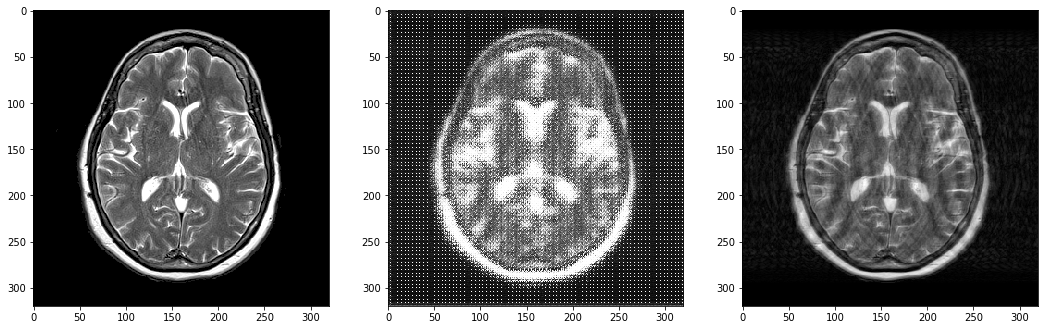

Source and restored:
	MAE	PSNR	SSIM
score	0.180	11.059	0.125

Source and sampled:
	MAE	PSNR	SSIM
score	0.060	20.983	0.587


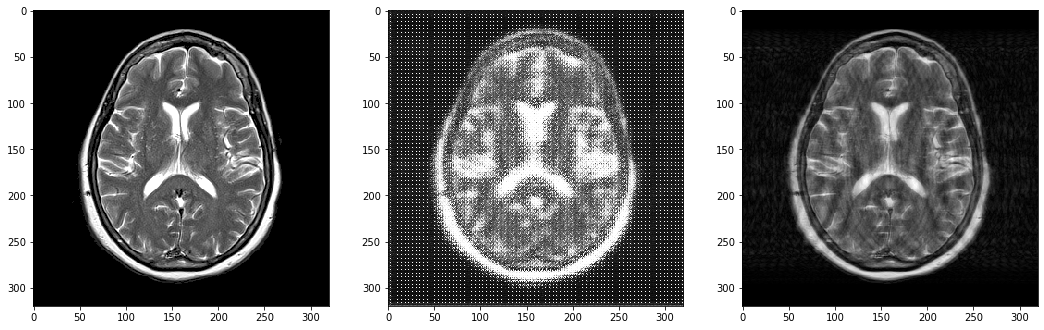

In [33]:
n = 3

for i, (source, sampled) in enumerate(train_loader, 1):

    restored = G(sampled)

    fig, axis = plt.subplots(1, 3, figsize=(18, 16))
    axis[0].imshow(source[0, 0], cmap='gray', vmin=0, vmax=1)
    axis[2].imshow(sampled[0, 0], cmap='gray', vmin=0, vmax=1)
    axis[1].imshow(restored[0, 0].data, cmap='gray', vmin=0, vmax=1)
    
    print('Source and restored:')
    compare_imgs(source.data.squeeze(), restored.data.squeeze(), verbose=True)
    print('\nSource and sampled:')
    compare_imgs(source.data.squeeze(), sampled.data.squeeze(), verbose=True)
    
    
    plt.show()

    if i >= n:
        break